<h1>Time Series Analysis - White Noise and Random Walks<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Statistical-Test" data-toc-modified-id="Statistical-Test-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Statistical Test</a></span><ul class="toc-item"><li><span><a href="#Stationarity" data-toc-modified-id="Stationarity-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Stationarity</a></span></li><li><span><a href="#Autocorrelation" data-toc-modified-id="Autocorrelation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Autocorrelation</a></span></li><li><span><a href="#Probability-Plots" data-toc-modified-id="Probability-Plots-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Probability Plots</a></span></li><li><span><a href="#Time-Series-Statistics-Plot-Agg" data-toc-modified-id="Time-Series-Statistics-Plot-Agg-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Time Series Statistics Plot Agg</a></span></li></ul></li><li><span><a href="#White-Noise" data-toc-modified-id="White-Noise-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>White Noise</a></span></li><li><span><a href="#Random-Walk" data-toc-modified-id="Random-Walk-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Random Walk</a></span></li><li><span><a href="#Fit-Random-Walk-Models-to-Financial-Data" data-toc-modified-id="Fit-Random-Walk-Models-to-Financial-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fit Random Walk Models to Financial Data</a></span><ul class="toc-item"><li><span><a href="#Fit-to-Simulated-Data" data-toc-modified-id="Fit-to-Simulated-Data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Fit to Simulated Data</a></span></li><li><span><a href="#Fit-to-Financial-Data" data-toc-modified-id="Fit-to-Financial-Data-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Fit to Financial Data</a></span></li></ul></li></ul></div>

In [10]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.stattools import adfuller, acf, pacf

import yfinance as yf

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('bmh')
plt.style.use('tableau-colorblind10')

# Statistical Test


## Stationarity

In [1]:
def plot_ts(x, ax=None):
    if ax is None:
        ax = plt.figure(figsize=(10, 4))
    
    ax.plot(x)
    
    ax.set_title("Time Series Analysis")
    ax.set_xlim((-0.5, len(x)+0.5))

             
def check_for_stationarity(x, cutoff=0.01):
    """The Augmented Dickey Fuller Test(ADF) is unit root test for stationarity.
    
    The null hypothesis for this test is that there is a unit root (non-stationary). We must observe 
    significant p-value to reject the null hypothesis. In other words, to convince ourselves that the 
    seriesis stationary.
    """
    
    pvalue = adfuller(x)[1]
    if pvalue < cutoff:
        print("The series is likely stationary.")
        return True
    else:
        print("The series is likely non-stationary.")
        return False

## Autocorrelation

In [12]:
def plot_acf(X, nlags=40, alpha=0.05, mode='ACF', ax=None):
    """The acf and pacf functions will return confidence intervals on all the autocorrelations.
    We can check if these intervals overlap with zero. If they do then we say that zero is within 
    the set confidence interval for the true parameter value, and don't treat the lag as having any 
    meaningful autocorrelation.
    """
    
    if ax is None:
        ax = plt.figure(figsize=(10, 4))
        
    
    if mode == 'ACF':
        X_acf, X_acf_confs = acf(X, nlags=nlags, alpha=alpha)
    else:
        X_acf, X_acf_confs = pacf(X, nlags=nlags, alpha=alpha)

        
    errorbars = np.ndarray((2, len(X_acf)))
    errorbars[0, :] = X_acf - X_acf_confs[:,0]
    errorbars[1, :] = X_acf_confs[:,1] - X_acf
    
    ax.errorbar(range(len(X_acf)), X_acf, yerr=errorbars, fmt='o', ecolor='gray', markersize=4, 
                 capthick=2, capsize=2)
    ax.axhline(y=0, linestyle='-', alpha=0.5)
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')
    ax.set_xlim((-0.5, nlags+0.5))
   
    ax.set_title(mode)

## Probability Plots

In [4]:
def plot_pp_qq(x, dist=None, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(10, 4))
        
        layout = (1, 2)
        qq_ax = plt.subplot2grid(layout, (0, 0))
        pp_ax = plt.subplot2grid(layout, (0, 1))
    else:
        qq_ax = ax[0]
        pp_ax = ax[1]
    
    if dist is None:
        dist = scs.norm(x.mean(), x.std())
    
    sm.ProbPlot(x).qqplot(line='s', ax=qq_ax);
    qq_ax.set_title('Q-Q plot')
    qq_ax.set_xlabel('Theoretical Probabilities')
    qq_ax.set_ylabel('Sample Probabilities')
    
    sm.ProbPlot(x, dist).ppplot(line='45', ax=pp_ax)
    pp_ax.set_title('P-P plot')
    pp_ax.set_xlabel('Theoretical Probabilities')
    pp_ax.set_ylabel('Sample Probabilities')


## Time Series Statistics Plot Agg

In [5]:
def plot_ts_stats_agg(y, lags=None, ts_name=None, figsize=(10, 8),):
    fig = plt.figure(figsize=figsize)
    layout = (3, 2)
    
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    qq_ax = plt.subplot2grid(layout, (2, 0))
    pp_ax = plt.subplot2grid(layout, (2, 1))
    
    plot_ts(y, ax=ts_ax)
    plot_acf(y, mode='ACF', ax=acf_ax)
    plot_acf(y, mode='PACF', ax=pacf_ax)
    plot_pp_qq(y, ax=[qq_ax, pp_ax])
    
    plt.tight_layout()

# White Noise

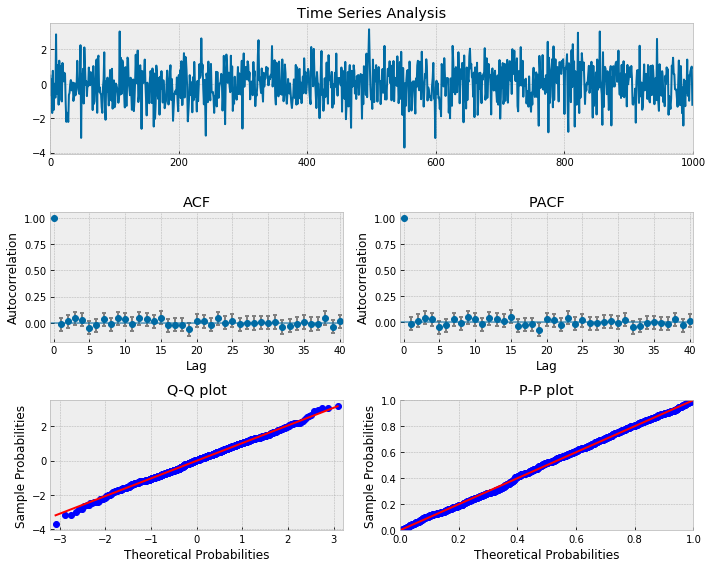

In [6]:
# generate a Gaussian white noise
np.random.seed(12)

y = np.random.normal(size=1000)

plot_ts_stats_agg(y)

# Random Walk

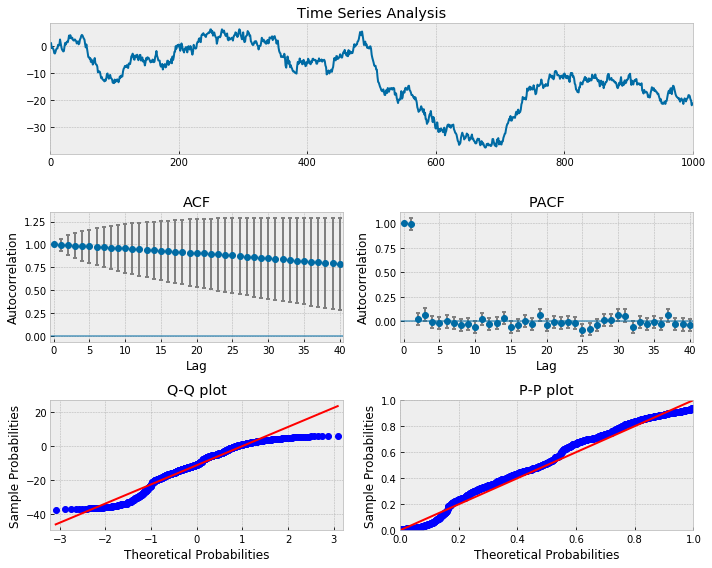

In [8]:
y = w = np.random.normal(size=1000)

for i in range(1000):
    y[i] = y[i-1] + w[i]

plot_ts_stats_agg(y)

# Fit Random Walk Models to Financial Data

## Fit to Simulated Data

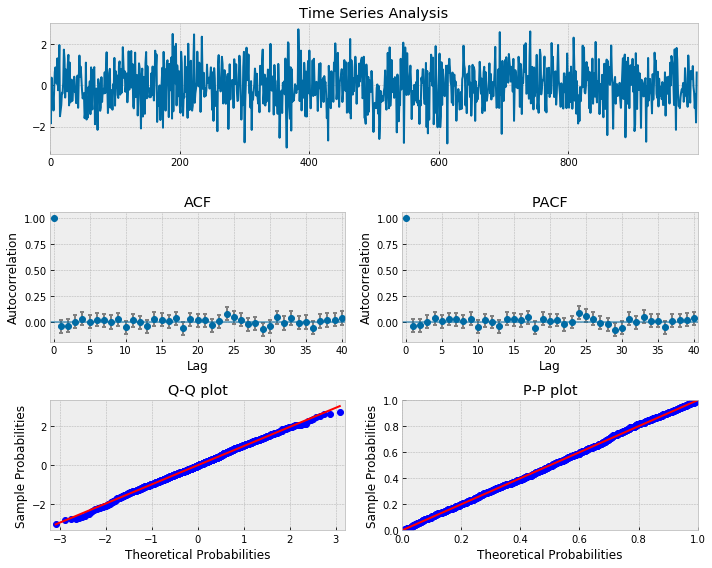

In [9]:
r = np.diff(y)

plot_ts_stats_agg(r)

## Fit to Financial Data

[*********************100%***********************]  1 of 1 completed
The series is likely stationary.


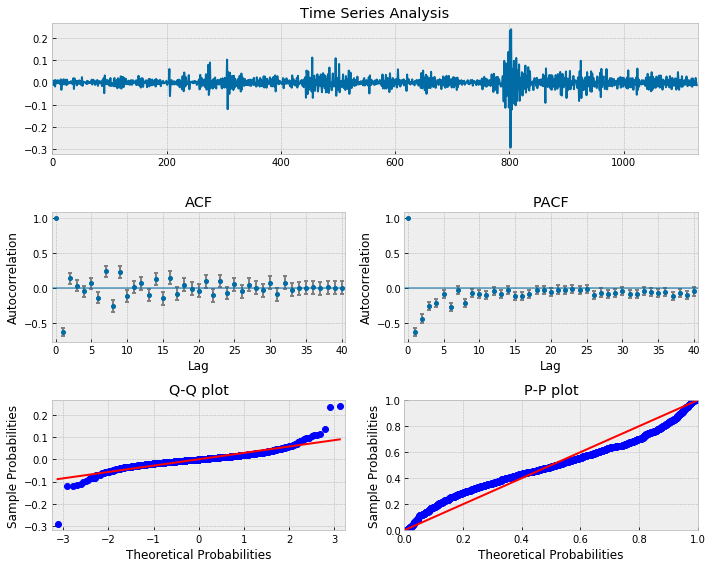

In [17]:
data = yf.download("MSFT", start="2017-01-01", end="2021-07-01")

data['lret'] = np.log(data['Adj Close']/data['Adj Close'].shift(1))

data.dropna(inplace=True)

check_for_stationarity(data['lret'])

r = np.diff(data['lret'])

plot_ts_stats_agg(r)